# Predict Diabetes

Author: Yifeng Xiong

Course Project, UC Irvine, Math 10, F22

## Introduction


Diabetes is one of the more common diseases nowadays. We hope to use machine learning to build some efficient and accurate models to assist doctors in diagnosing the disease. In this dataset, all patients here are females at least 21 years old of Pima Indian heritage. There are 8 features: 
* Pregnancies
* Glucose
* BloodPressure
* SkinThickness
* Insulin
* BMI
* DiabetesPedigreeFunction
* Age

## Random state selection

Random state in this notebook is set to 42. Because 42 is the answer to the Ultimate Question of Life, the Universe, and Everything. (The Hitchhiker's Guide to the Galaxy by Douglas Adams)

## Part 0: Import Libraries

Libraries and functions that covered in Math 10:

In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import numpy as np

Libraries and functions for extra topics:

In [2]:
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

/shared-libs/python3.10/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Load and Preprocess Data

In this section, I will load the data using pandas, take a brief view of the data, and create train and test dataset.

Firstly, let's load the dataset and take a look at the first five rows.

In [3]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The dataset has 9 features in total, and the last feature is the one we want to predict. Class 1 means "tested positive for diabetes."

Let's take a look at the shape of the dataframe.

In [4]:
df.shape

(768, 9)

It's also important to check whether there is nan in each column. And based on the result below, we do not need to drop any rows.

In [5]:
df.isna().any(axis=0)

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

**Extra 1** (code from Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow page 49)

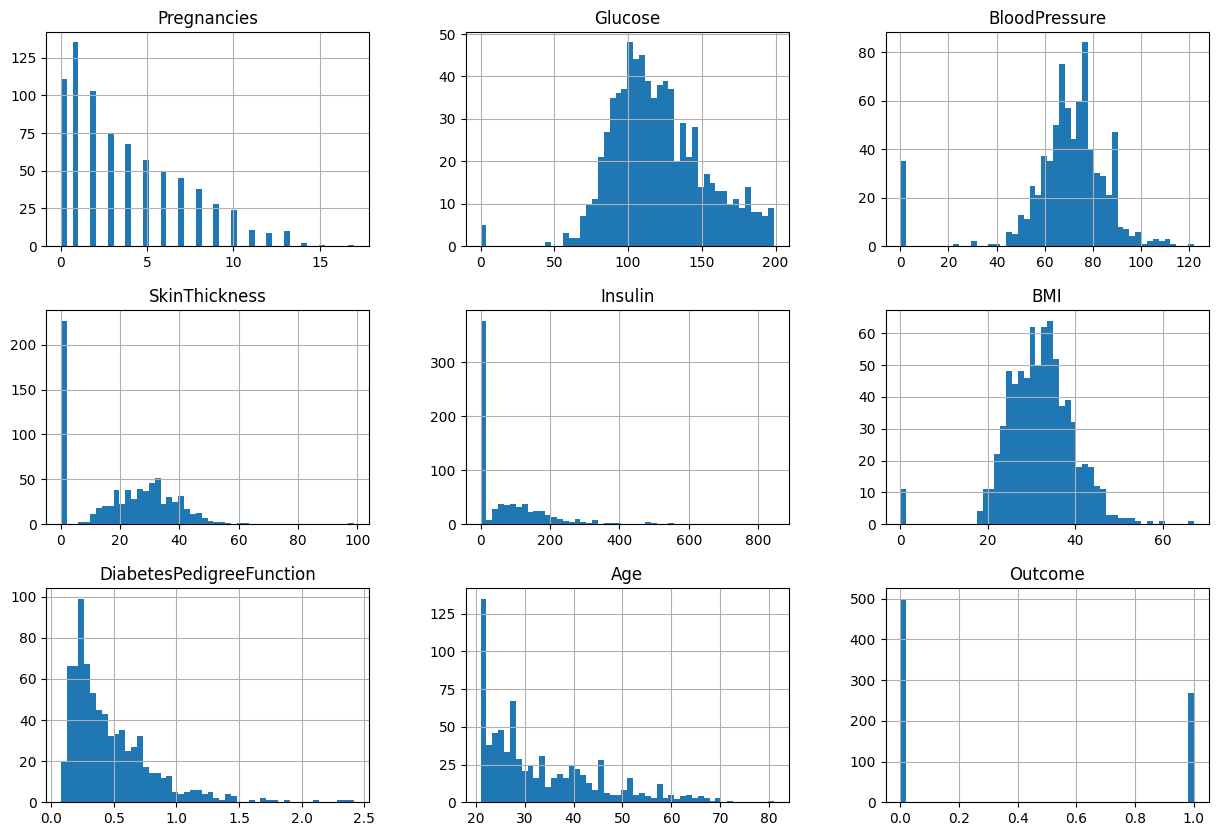

In [6]:
df.hist(bins=50,figsize=(15,10))
plt.show()

Based on the figure, we can see each feature has different range. I will use StandardScaler if needed.

It is important to split the training data and test data early. So that we will use no information from test data.

In [7]:
input_cols = [c for c in df.columns if c != "Outcome"]
X = df[input_cols]
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Some models may need scaled data, so let's do it now.

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = X_train.copy()
X_train_scaled[X_train.columns] = scaler.transform(X_train)

We also need to scale the test data.
However, we should **not** create a new StandardScaler but just use the one from training data.

In [9]:
X_test_scaled = X_test.copy()
X_test_scaled[X_test.columns] = scaler.transform(X_test)

**Extra 2**
Another way to take a brief look of the dataset. Based on the result, we can say now all features in X_train_scaled are much closer.

In [10]:
X_train_scaled.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02,6.140000e+02
mean,1.735854e-17,-2.169817e-17,6.943414e-17,1.041512e-16,-2.603780e-17,-5.699386e-16,1.562268e-16,-3.761016e-17
std,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00,1.000815e+00
min,-1.130523e+00,-3.775663e+00,-3.752683e+00,-1.322774e+00,-7.012055e-01,-4.135256e+00,-1.162210e+00,-1.035940e+00
25%,-8.284601e-01,-6.515379e-01,-2.927587e-01,-1.322774e+00,-7.012055e-01,-6.313921e-01,-6.764304e-01,-7.749361e-01
50%,-2.243336e-01,-1.204366e-01,1.397318e-01,1.686602e-01,-3.352683e-01,2.147879e-03,-2.872124e-01,-3.399290e-01
75%,6.818561e-01,5.668710e-01,5.722222e-01,7.522648e-01,4.159792e-01,5.678085e-01,4.295726e-01,6.170866e-01
max,4.004552e+00,2.441346e+00,2.842797e+00,2.762458e+00,6.583098e+00,4.540363e+00,5.796175e+00,4.184145e+00


## Part 2: Decision Tree

The reason I use Decision Tree at first is that I want to find several important features in the dataset.

Firstly, let's initiate a Deicison Tree with no limit, no limit means the Decision Tree can go as deep as it want.

In [11]:
clf_DT_no_limit = DecisionTreeClassifier(random_state=42)
clf_DT_no_limit.fit(X_train, y_train.astype("str"))
clf_DT_no_limit.score(X_train, y_train.astype("str"))

1.0

Based on the [explanation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.score) of function score, we can say the Decision Tree above get 100% accuracy on training data. It is not surprised since there is no limit on this model, so it can have very large depth and number of leaves. Let's test it on the test dataset.

In [12]:
clf_DT_no_limit.score(X_test, y_test.astype("str"))

0.7467532467532467

Obviously, this Decision Tree overfits the training data.

Then let's add some limit on the Decision Tree. We test max_leaf_nodes from 2 to 40 and draw the training and testing loss curve together.

In [13]:
DT_train_dict = {}
DT_test_dict = {}

for n in range(2,40):
    _clf = DecisionTreeClassifier(max_leaf_nodes=n, random_state=42)
    _clf.fit(X_train, y_train.astype("str"))
    train_error = log_loss(y_train.astype("str"), _clf.predict_proba(X_train))
    DT_train_dict[n] = train_error
    test_error = log_loss(y_test.astype("str"), _clf.predict_proba(X_test))
    DT_test_dict[n] = test_error
train_ser = pd.Series(DT_train_dict)
test_ser = pd.Series(DT_test_dict)
train_ser.name = "train"
test_ser.name = "test"
df_loss = pd.concat((train_ser, test_ser), axis=1)
df_loss.reset_index(inplace=True)
df_loss.rename({"index": "max_leaf_nodes"}, axis=1, inplace=True)
df_melted = df_loss.melt(id_vars="max_leaf_nodes", var_name="Type", value_name="Loss")
c_DT = alt.Chart(df_melted).mark_line().encode(
    x="max_leaf_nodes",
    y="Loss",
    color="Type"
)
c_DT

alt.Chart(...)

Max_leaf_nodes = 5 is enough for the Decision Tree. After that, the difference between train and test curve is too large, which means overfitting the training data.

In [14]:
clf_DT = DecisionTreeClassifier(max_leaf_nodes=5, random_state=42)
clf_DT.fit(X_train, y_train.astype("str"))
print("Training Score: ", clf_DT.score(X_train, y_train.astype("str")))
print("Test Score: ", clf_DT.score(X_test, y_test.astype("str")))

Training Score:  0.7719869706840391
Test Score:  0.7727272727272727


Decision Tree gets 77.27% accuracy on test data. We store the predict result and accuracy for future use.

In [15]:
DT_acc = clf_DT.score(X_test, y_test.astype("str"))
DT_result = clf_DT.predict(X_test)

Let's take a look at the Decison Tree by plot_tree.

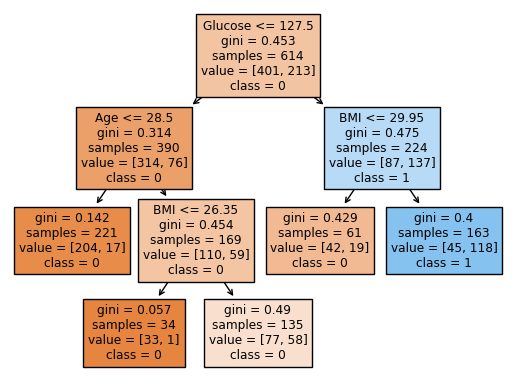

In [16]:
fig = plt.figure()
_ = plot_tree(clf_DT, 
                   feature_names=clf_DT.feature_names_in_,
                   class_names=clf_DT.classes_,
                   filled=True)

Based on the graph, Glucose, Age and BMI are the features that been used in the Decision Tree. It seems these three features are the most important in the dataset. We also want numerical data to support the conclusion.

In [17]:
pd.Series(clf_DT.feature_importances_, index=clf_DT.feature_names_in_)

Pregnancies                 0.000000
Glucose                     0.565357
BloodPressure               0.000000
SkinThickness               0.000000
Insulin                     0.000000
BMI                         0.272307
DiabetesPedigreeFunction    0.000000
Age                         0.162336
dtype: float64

Thus, we can say the importance is: Glucose > BMI > Age.

## Part 2: Random Forest

The next model we will try is random forest. Decision Tree gives a good result, and I expect Random Forest will do better.

In [18]:
RF_train_dict = {}
RF_test_dict = {}

for n in range(2,40):
    _clf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=n, random_state=42)
    _clf.fit(X_train, y_train.astype("str"))
    train_error = log_loss(y_train.astype("str"), _clf.predict_proba(X_train))
    RF_train_dict[n] = train_error
    test_error = log_loss(y_test.astype("str"), _clf.predict_proba(X_test))
    RF_test_dict[n] = test_error
train_ser = pd.Series(RF_train_dict)
test_ser = pd.Series(RF_test_dict)
train_ser.name = "train"
test_ser.name = "test"
df_loss = pd.concat((train_ser, test_ser), axis=1)
df_loss.reset_index(inplace=True)
df_loss.rename({"index": "max_leaf_nodes"}, axis=1, inplace=True)
df_melted = df_loss.melt(id_vars="max_leaf_nodes", var_name="Type", value_name="Loss")
c_RF = alt.Chart(df_melted).mark_line().encode(
    x="max_leaf_nodes",
    y=alt.Y("Loss",scale=alt.Scale(domain=[0.0, 2.4])), 
    color="Type"
)
alt.hconcat(c_RF, c_DT)

alt.HConcatChart(...)

The left figure above is the training and test loss for Random Forest, while the right figure is the loss for Decision Tree. We can see the training loss are decreasing similarly, but the test loss is significantly different. These figures shows how Random Forest prevent models from overfitting.

I test nodes from 3 to 10, 7 gives the best result.

In [19]:
clf_RF = RandomForestClassifier(n_estimators=200, max_leaf_nodes=7, random_state=42)
clf_RF.fit(X_train, y_train.astype("str"))
print("Training Score: ", clf_RF.score(X_train, y_train.astype("str")))
print("Test Score: ", clf_RF.score(X_test, y_test.astype("str")))

Training Score:  0.8029315960912052
Test Score:  0.7857142857142857


Random Forest doesn't get much improve in this task. It gets 78.57% accuracy on the test dataset. But it shows how good it is for prevent overfitting. We store the result for future use.

In [20]:
RF_acc = clf_RF.score(X_test, y_test.astype("str"))
RF_result = clf_RF.predict(X_test)

Similar to Random Forest, let's take a look at the feature importance.

In [21]:
pd.Series(clf_RF.feature_importances_, index=clf_RF.feature_names_in_)

Pregnancies                 0.052909
Glucose                     0.401967
BloodPressure               0.031670
SkinThickness               0.022298
Insulin                     0.054308
BMI                         0.186646
DiabetesPedigreeFunction    0.050335
Age                         0.199866
dtype: float64

We get very similar conclusion to Random Forest. But in Random Forest, Age seems to be a little much important than BMI.

## Part 3: Kmeans

In this part, we use Kmeans to do clustering on the dataset. We will use the top 3 important features for kmeans training.

Firstly, we will create a dataframe with the columns we want. Note that range affects the performance of Kmeans, so we will use the scaled data.

In [22]:
kmeans_cols = ["Glucose", "BMI", "Age"]
X_train_scaled_kmeans = X_train_scaled[kmeans_cols].copy()

Then we will initiate a kmeans class with n_clusters = 2. The reason that we set it to 2 is because we know there will be two classes: positive for diabetes or not.

In [23]:
kmeans = KMeans(n_clusters=2,random_state=42)
kmeans.fit(X_train_scaled_kmeans)
X_train_scaled_kmeans["y_predict"] = kmeans.predict(X_train_scaled_kmeans)
X_train_scaled_kmeans["y"] = list(y_train)

Before calculating the accuracy of the kmeans method, there is one more thing we need to do. Since Kmeans is an unsupervised method, it will divide the data into two clusters, but which one is class 1 has no difference. So we will plot the prediction and see which class it predict is more likely to be "positive" in the training data.

We choose Glucose and BMI for x and y axis.

In [24]:
c1 = alt.Chart(X_train_scaled_kmeans).mark_circle().encode(
    x="Glucose",
    y="BMI",
    color="y:N",
    tooltip=["y","Glucose","BMI","Age"]
)

c2 = alt.Chart(X_train_scaled_kmeans).mark_circle().encode(
    x="Glucose",
    y="BMI",
    color="y_predict:N",
    tooltip=["y_predict","Glucose","BMI","Age"]
)

alt.hconcat(c1,c2)

alt.HConcatChart(...)

Based on the plot, we can say the class 1 in **y_predict** is more likely to be the class 0 in **y**.

Then we can calculate the training accuracy.

In [25]:
print("Training accuracy",
(X_train_scaled_kmeans["y"] != X_train_scaled_kmeans["y_predict"]).sum() / X_train_scaled_kmeans.shape[0])

Training accuracy 0.754071661237785


We need to test the model to check whether it overfit.

In [26]:
X_test_scaled_kmeans = X_test_scaled[kmeans_cols].copy()
kmeans_result = kmeans.predict(X_test_scaled_kmeans)
X_test_scaled_kmeans["y_predict"] = kmeans_result
X_test_scaled_kmeans["y"] = list(y_test)

In [27]:
print("Test accuracy",
(X_test_scaled_kmeans["y"] != X_test_scaled_kmeans["y_predict"]).sum() / X_test_scaled_kmeans.shape[0])

Test accuracy 0.6948051948051948


It seems the model is overfitting a bit. I think one possible reason is that there are much more "negative" than "positive" in the training data.

In [28]:
y_train.value_counts()

0    401
1    213
Name: Outcome, dtype: int64

Note that there are 65% class 0 in the training data, much more than 50%. The idea comes to my mind is to sample 213 rows of class 0.

In [29]:
training_data = X_train_scaled.copy()
training_data["y"] = y_train
training_data_class0 = training_data[training_data["y"]==0]
training_data_class1 = training_data[training_data["y"]==1]
training_data_class0_sample = training_data_class0.sample(n=213,random_state=42)

Now we have 213 class 0 and 213 class 1, we will concatnate them together to create the new training data.

In [30]:
X_train_scaled_balanced = pd.concat([training_data_class0_sample, training_data_class1])
y_train_balanced = X_train_scaled_balanced["y"]
X_train_scaled_balanced.drop(columns=["y"],inplace=True)

Now let's fit a kmeans model on the balanced data.

In [31]:
X_train_scaled_kmeans_balanced = X_train_scaled_balanced[kmeans_cols].copy()
kmeans_balanced = KMeans(n_clusters=2,random_state=42)
kmeans_balanced.fit(X_train_scaled_kmeans_balanced)
X_train_scaled_kmeans_balanced["y_predict"] = kmeans_balanced.predict(X_train_scaled_kmeans_balanced)
X_train_scaled_kmeans_balanced["y"] = list(y_train_balanced)

Similar to before, we will plot the prediction.

In [32]:
c1 = alt.Chart(X_train_scaled_kmeans_balanced).mark_circle().encode(
    x="Glucose",
    y="BMI",
    color="y:N",
    tooltip=["y","Glucose","BMI","Age"]
)

c2 = alt.Chart(X_train_scaled_kmeans_balanced).mark_circle().encode(
    x="Glucose",
    y="BMI",
    color="y_predict:N",
    tooltip=["y_predict","Glucose","BMI","Age"]
)

alt.hconcat(c1,c2)

alt.HConcatChart(...)

Based on the plot, we can say the class 1 in **y_predict** is more likely to be the class 1 in **y**.

In [33]:
print("Training accuracy",
(X_train_scaled_kmeans_balanced["y"] == X_train_scaled_kmeans_balanced["y_predict"]).sum() / X_train_scaled_kmeans_balanced.shape[0])

Training accuracy 0.7535211267605634


In [34]:
X_test_scaled_kmeans_balanced = X_test_scaled[kmeans_cols].copy()
X_test_scaled_kmeans_balanced["y_predict"] = kmeans_balanced.predict(X_test_scaled_kmeans_balanced)
X_test_scaled_kmeans_balanced["y"] = list(y_test)

In [35]:
print("Test accuracy",
(X_test_scaled_kmeans_balanced["y"] == X_test_scaled_kmeans_balanced["y_predict"]).sum() / X_test_scaled_kmeans_balanced.shape[0])

Test accuracy 0.7142857142857143


The new kmeans model looks a little better. We will store the result for future use.

In [36]:
kmeans_balanced_result = kmeans_balanced.predict(X_test_scaled_kmeans_balanced[kmeans_cols])
kmeans_balanced_acc = (X_test_scaled_kmeans_balanced["y"] == X_test_scaled_kmeans_balanced["y_predict"]).sum() / X_test_scaled_kmeans_balanced.shape[0]

## Part 4: Kmeans with PCA

**Extra3**
In this part, I will use PCA to decrease the dimension into 2 and then use kmeans to do clustering. And I will also use the balanced dataset.

In [37]:
pca = PCA(n_components=2)
pca.fit(X_train_scaled_balanced)
X_train_scaled_PCA = pd.DataFrame(pca.transform(X_train_scaled_balanced),columns=["PCA0","PCA1"])
kmeans_PCA = KMeans(n_clusters=2,random_state=42)
kmeans_PCA.fit(X_train_scaled_PCA)
X_train_scaled_PCA["y_predict"] = kmeans_PCA.predict(X_train_scaled_PCA)
X_train_scaled_PCA["y"] = list(y_train_balanced)
c1 = alt.Chart(X_train_scaled_PCA).mark_circle().encode(
    x="PCA0",
    y="PCA1",
    color="y:N"
)

c2 = alt.Chart(X_train_scaled_PCA).mark_circle().encode(
    x="PCA0",
    y="PCA1",
    color="y_predict:N"
)

alt.hconcat(c1,c2)

alt.HConcatChart(...)

Based on the plot, we can say the class 1 in **y_predict** is more likely to be the class 0 in **y**.

In [38]:
print("Training accuracy",
(X_train_scaled_PCA["y"] != X_train_scaled_PCA["y_predict"]).sum() / X_train_scaled_PCA.shape[0])

Training accuracy 0.7065727699530516


In [39]:
X_test_scaled_PCA = pd.DataFrame(pca.transform(X_test_scaled),columns=["PCA0","PCA1"])

X_test_scaled_PCA["y_predict"] = kmeans_PCA.predict(X_test_scaled_PCA)
X_test_scaled_PCA["y"] = list(y_test)
print("Test accuracy",
(X_test_scaled_PCA["y"] != X_test_scaled_PCA["y_predict"]).sum() / X_test_scaled_PCA.shape[0])

Test accuracy 0.6493506493506493


PCA is not a good strategy in this task. However, we will still store the result for future use.

In [40]:
PCA_result = kmeans_PCA.predict(X_test_scaled_PCA[["PCA0","PCA1"]])
PCA_acc = (X_test_scaled_PCA["y"] != X_test_scaled_PCA["y_predict"]).sum() / X_test_scaled_PCA.shape[0]

## Part 5: Logistic Regression

**Extra 4**
In this part, we will use logistic regression to predict.

In [41]:
clf_LR = LogisticRegression(random_state=42)
clf_LR.fit(X_train, y_train)

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Based on the error message, we need to increase the max_iter.

In [42]:
clf_LR = LogisticRegression(max_iter=500,random_state=42)
clf_LR.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [43]:
print("Training Score: ", clf_LR.score(X_train, y_train))
print("Test Score: ", clf_LR.score(X_test, y_test))

Training Score:  0.7703583061889251
Test Score:  0.7467532467532467


Logistic regression is not overfitting the data. So we will store the result for future use.

In [44]:
LR_result = clf_LR.predict(X_test)
LR_acc = clf_LR.score(X_test, y_test)

What's more, we can plot the coefficient for each feature.

In [45]:
_df = pd.DataFrame({"feature": list(X_train.columns), "coef": clf_LR.coef_[0]})
alt.Chart(_df).mark_bar().encode(
    y="feature",
    x="coef",
    tooltip=["feature","coef"]
)

alt.Chart(...)

Based on the figure, it seems DiabetesPedigreeFunction is the most important feature, which doesn't match the conclusion from Random Forest and Decision Tree. The reason is that the dataset we use to train Logistic Regression is unscaled data. The range will effect the coefficient. To view the importance of each feature, we should use scaled data.

In [46]:
clf_LR_scaled = LogisticRegression(max_iter=500,random_state=42)
clf_LR_scaled.fit(X_train_scaled, y_train)
print("Training Score: ", clf_LR_scaled.score(X_train_scaled, y_train))
print("Test Score: ", clf_LR_scaled.score(X_test_scaled, y_test))
_df = pd.DataFrame({"feature": list(X_train_scaled.columns), "coef": clf_LR_scaled.coef_[0]})
alt.Chart(_df).mark_bar().encode(
    y="feature",
    x="coef",
    tooltip=["feature","coef"]
)

Training Score:  0.7703583061889251
Test Score:  0.7532467532467533


alt.Chart(...)

Now it's clear that Glucose, BMI, and Age are the top 3 important features.

## Part 6: Neural Network

**Extra 5**
Nowadays, neural network, or deep learning, is a common strategy to do prediction. In this part, I will use pytorch to build a very simple fully connected neural network to predict.

The following code has no reference since I'm very familiar with Pytorch.
This neural network contains 5 linear layers, the first four activation function is ReLU, and the last one is sigmoid. I would like to use the output of the network, a length 2 tensor, to represent the probability that the input is belong to each class.

In [47]:
class simple_net(nn.Module):
    def __init__(self):
        super(simple_net, self).__init__()

        self.linear1 = nn.Linear(8,32)
        self.linear2 = nn.Linear(32,32)
        self.linear3 = nn.Linear(32,16)
        self.linear4 = nn.Linear(16,4)
        self.linear5 = nn.Linear(4,2)

        self.relu = nn.ReLU()
        self.last = nn.Sigmoid()

    def forward(self, x):
        out = self.relu(self.linear1(x))
        out = self.relu(self.linear2(out))
        out = self.relu(self.linear3(out))
        out = self.relu(self.linear4(out))
        out = self.last(self.linear5(out))

        return out

Since our data is stored as a dataframe, we need to write our own dataset class. The code is copied from https://androidkt.com/load-pandas-dataframe-using-dataset-and-dataloader-in-pytorch/

In [48]:
class MyDataset(Dataset):
 
  def __init__(self, dfX, y):
 
    x=dfX.values
 
    self.x_train=torch.tensor(x).float()
    self.y_train=torch.tensor(y).float()
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

Note that the output of the neural network is a length 2 tensor, so we will use OneHotEncoder to encode each class into a length 2 array.

In [49]:
encoder = OneHotEncoder()
encoder.fit(pd.DataFrame(y_train))
y_train_onehot = encoder.transform(pd.DataFrame(y_train)).toarray()
y_test_onehot = encoder.transform(pd.DataFrame(y_test)).toarray()

Now it's time to train the neural network. Note that Deepnote has no GPU available for Education plan, so I use cpu to train the network. The loss I use is BCELoss (Binary Cross Entropy between the target and the input probabilities.)

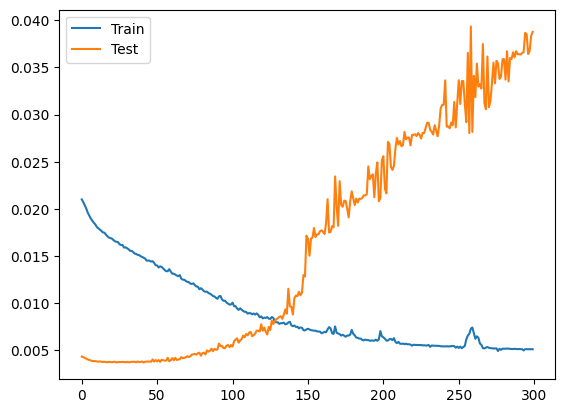

In [50]:
device = 'cpu'
batch_size = 32
epoch = 300
dataset = MyDataset(X_train_scaled, y_train_onehot)
train_dataset = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
net = simple_net().to(device)
criterion = nn.BCELoss()
train_loss_list = []
test_loss_list = []
optimizer = torch.optim.Adam(net.parameters())
for i in range(epoch):
    total_loss = 0
    net.train()
    for j, (_x, _y) in enumerate(train_dataset):
        _y_predicted = net(_x)
        loss = criterion(_y_predicted, _y)
        loss /= batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    net.eval()
    test_predicted = net(torch.tensor(X_test_scaled.values).float())
    test_loss = criterion(test_predicted, torch.tensor(y_test_onehot).float())

    train_loss_list.append(total_loss / (j+1))
    test_loss_list.append(test_loss.item() / len(y_test_onehot))

plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.legend(['Train','Test'])
plt.show()

Based on the figure, epoch 130 is a good stop point.

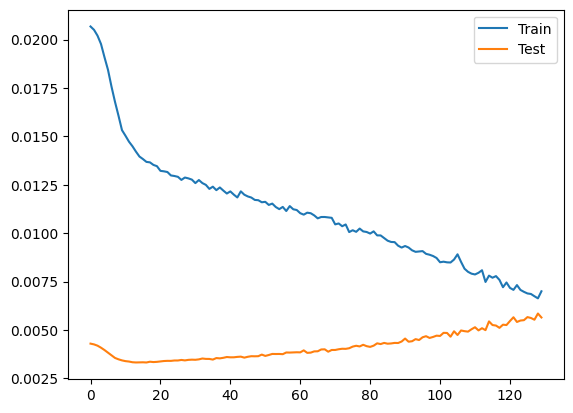

Test accuracy:  0.7402597402597403


In [57]:
dataset = MyDataset(X_train_scaled, y_train_onehot)
train_dataset = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
net = simple_net().to(device)
criterion = nn.BCELoss()
train_loss_list = []
test_loss_list = []
optimizer = torch.optim.Adam(net.parameters())
for i in range(130):
    total_loss = 0
    net.train()
    for j, (_x, _y) in enumerate(train_dataset):
        _y_predicted = net(_x)
        loss = criterion(_y_predicted, _y)
        loss /= batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    net.eval()
    test_predicted = net(torch.tensor(X_test_scaled.values).float())
    test_loss = criterion(test_predicted, torch.tensor(y_test_onehot).float())

    train_loss_list.append(total_loss / (j+1))
    test_loss_list.append(test_loss.item() / len(y_test_onehot))
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.legend(['Train','Test'])
plt.show()

NN_result = net(torch.tensor(X_test_scaled.values).float())

NN_result = encoder.inverse_transform([[1,0] if i[0] > i[1] else [0,1] for i in NN_result]).flatten()
NN_acc = (NN_result == y_test).sum() / len(NN_result)
print("Test accuracy: ", NN_acc)

## Part 7: Ensemble Model

**Extra 6**
In this part, I will ensemble all models I create before, give them weights based on the accuracy. Then I will calculate the result by multiply the weights to their prediction. If the final score is greater than 0.5, then we believe the prediction is 1. This idea comes from CS 178.

The following is the accuracy for each model. We normalize the array to get the weight for each model.

In [58]:
acc_array = np.array([DT_acc, LR_acc, RF_acc, kmeans_balanced_acc, PCA_acc, NN_acc])
acc_array = acc_array / sum(acc_array)

The following is the predict result for each model.

In [59]:
result_array = np.array([DT_result.astype(int), LR_result, RF_result.astype(int), kmeans_balanced_result, PCA_result, NN_result])

The ensemble result is using each model's weight times the result and then sum up.

In [60]:
ensemble_result = np.multiply(acc_array.reshape(-1,1), result_array)

The last thing we should do is compare the result with a threshold we set: 0.5. If score is larger than 0.5, then we believe it's class 1, otherwise, it's class 0.

In [61]:
ensemble_result = (ensemble_result.sum(axis=0) >= 0.5).astype(int)

Here is the final accuracy.

In [62]:
ensemble_acc = (ensemble_result == y_test).sum() / len(y_test)
ensemble_acc

0.7987012987012987

We put all model's accuracy together and make a barchart to have a clear view of the performance of each model.

In [82]:
df_acc = pd.DataFrame({"Model":["Decision Tree","Random Forest","Kmeans",
                                "Kmeans with PCA","Logistic Regression",
                                "Neural Network","Ensemble"],
                        "Accuracy":[DT_acc, RF_acc,kmeans_balanced_acc,PCA_acc,LR_acc,NN_acc,ensemble_acc]})

sel = alt.selection_single(fields=["Model"], bind="legend")
alt.Chart(df_acc).mark_bar().encode(
    x=alt.X("Model",sort="y"),
    y=alt.Y("Accuracy",scale=alt.Scale(domain=[0.5, 0.8])),
    color=alt.condition(sel,"Model", alt.value("lightgrey")),
    opacity=alt.condition(sel, alt.value(1), alt.value(0.2)),
    tooltip=["Model","Accuracy"]
).add_selection(sel)

alt.Chart(...)

## Summary

In this project, we build six models to predict positive of diabetes or not. The top 3 important feature to do prediction is Glucose, BMI, and Age. Five models get accuracy over 70%, and Decision Tree and Random Forest get over 75%. We also ensemble these models and get 79.87% accuracy, which is better than any single model.

## References

Your code above should include references.  Here is some additional space for references.

* What is the source of your dataset(s)?

The dataset is from Kaggle: https://www.kaggle.com/datasets/mathchi/diabetes-data-set

* List any other references that you found helpful.

[Math 10 Notes](https://christopherdavisuci.github.io/UCI-Math-10-F22/intro.html)
Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, by Aurelien Geron
[Load Pandas Dataframe using Dataset and DataLoader in PyTorch](https://androidkt.com/load-pandas-dataframe-using-dataset-and-dataloader-in-pytorch/)

## Submission

Using the Share button at the top right, **enable Comment privileges** for anyone with a link to the project. Then submit that link on Canvas.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e4ec2d9b-0a4f-47c6-a480-b7b5a104e368' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>